In [1]:
import io
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import json

In [2]:
labels_file = 'imagenet-simple-labels.json'
image_file = 'test.jpg'

In [3]:
net = models.resnet18(pretrained=True)

In [4]:
net  # 查看网络结构

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

可以看到，满足 CAM 的要求，CONV->GAP->FC

In [5]:
final_conv_name = 'layer4'

In [6]:
net.eval()

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(final_conv_name).register_forward_hook(hook_feature)

In [7]:
for param in net.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 7, 7])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch

可以看到，倒数第二层是全连接层的权重

In [8]:
params = list(net.parameters())
weights = np.squeeze(params[-2].data.numpy())

In [9]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

In [10]:
# load test image
img_pil = Image.open(image_file)
img_tensor = preprocess(img_pil)
# 在最前面加一个维度，（batch_size, channels, h, w）
img_tensor = img_tensor.unsqueeze(0)

In [11]:
logit = net(img_tensor)

In [12]:
scores = F.softmax(logit, dim=1).data.squeeze()  # 使用 softmax 层打个分

In [13]:
# 使用 pytorch Tensor 的排序，降序
sorted_scores, idx = scores.sort(dim=0, descending=True)

In [14]:
sorted_scores, idx = sorted_scores.numpy(), idx.numpy()

In [15]:
sorted_scores[:5], idx[:5]

(array([0.51880246, 0.12367388, 0.11498982, 0.10427404, 0.03544746],
       dtype=float32),
 array([671, 970, 444, 880, 975], dtype=int64))

In [16]:
# load the imagenet category list
with open(labels_file) as f:
    classes = json.load(f)
    
classes[:5]

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark']

In [17]:
for val in idx[:5]:
    print(classes[val])

mountain bike
alp
tandem bicycle
unicycle
lakeshore


In [18]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [19]:
CAMs = returnCAM(features_blobs[0], weights, [idx[0]])

In [20]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

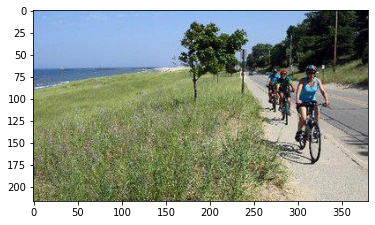

In [21]:
# img = plt.imread(image_file)  # RGB
# plt.imshow(img)
plt.imshow(img_pil)

In [22]:
type(CAMs[0]), CAMs[0].shape

(numpy.ndarray, (256, 256))

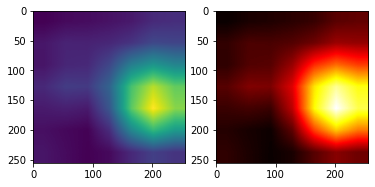

In [23]:
import seaborn as sns

# plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(CAMs[0])  # 查看注意力图

plt.subplot(122)
# sns.heatmap(CAMs[0]).invert_yaxis()  # 热力图
plt.imshow(CAMs[0], cmap=plt.cm.hot)
# plt.colorbar()
plt.show()

img.shape (216, 380, 3)


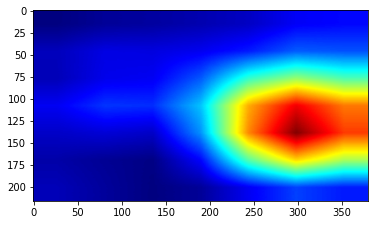

In [24]:
# 把注意力图 resize 成跟原图一样大的
# img = np.asarray(img_pil)
img = cv2.imread('test.jpg')
print("img.shape", img.shape)
height, width, _ = img.shape
# heatmap = Image.fromarray(CAMs[0]).resize((width, height))

heatmap = cv2.resize(CAMs[0],(width, height))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# opecv 和 plt 的通道不一样，需要变成RGB的
heatmap =  cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
plt.imshow(heatmap)

In [25]:
heatmap.shape

(216, 380, 3)

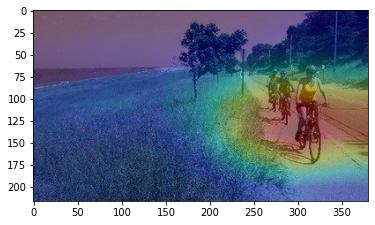

In [26]:
# 叠加一下再显示
result = (heatmap * 0.3 + img * 0.5) / 255
plt.imshow(result)